## Setup

___

#### Install dependencies

In [29]:
# %%bash
!pip install numpy pandas matplotlib torch torchvision scikit-learn seaborn
!pip install opencv-python

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


#### Import Dependencies

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import os
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from image_dataloader import SocialSignalDataset


#### Initialize constants

In [ ]:
# dataset
dataset_path = 'data/train'

image_length = 112
image_size = (image_length, image_length)

label_mapping = {
    0: "surprise",
    1: "fear"
}

# loaders
batch_size = 16

# model training
num_epochs =  5


## Dataset

---

#### Load and transform the dataset

In [ ]:
img_transform = transforms.Compose([
    transforms.Grayscale(3), # RGB
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = SocialSignalDataset(root_dir=dataset_path, transform=img_transform)

#### Split data set into training and validation

In [12]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True) 

# Check input size for forward feed network
for inputs, labels in train_loader:
    print("Input shape:", inputs.shape)
    print("Labels shape:", labels.shape)
    break  # We only want to check the first batch

Input shape: torch.Size([16, 3, 112, 112])
Labels shape: torch.Size([16])


## Model Setup
___

#### CNN + LSTM

In [14]:
class SocialSignalModel(nn.Module):
    def __init__(self, num_classes=2):
        super(SocialSignalModel, self).__init__()
        """"
        input_channel: 3 or 4 // test which one gets better inputs
            - 3: for RGB
            - 4: +1 for Depth from camera
        num_classes: 2 
            0 for surprise, 1 for fear
        """
        
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        ) 
        
        # Input size 128 * 14 * 14
        self.in_features = 128 * 14 * 14 #Flattened size after 3 Conv2d Layers and Pooling
        self.fc = nn.Linear(self.in_features, num_classes) # in_features = batch_size

    def forward(self, x):
        # TODO: IMPLEMENT
        # CNN --> Conv2d(N,Cin,H,W) --> (N, C_out, H_out,W_out)
        x = self.cnn(x)

        # Flatten 
        x = x.view(-1,self.in_features)

        # Fully Connected Layer
        x = self.fc(x)
        
        return x

#### Training

In [ ]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
model = SocialSignalModel().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001) 

# From Assignment 3 Training
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Loop over each batch
    for i, (sequences, labels) in enumerate(train_loader):
        sequences, labels = sequences.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(sequences)

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Optimize the model
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        running_loss += loss.item()

    # Print statistics for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # if epoch%5 == 0: # change the saving frequency as you want
    #     model_path = os.path.join('./model_configs', f'image_lstm_model_{epoch}.pth')
    #     torch.save(model.state_dict(), model_path)

Epoch [1/5], Loss: 0.8044, Accuracy: 51.20%
Epoch [2/5], Loss: 0.6803, Accuracy: 56.63%
Epoch [3/5], Loss: 0.6415, Accuracy: 63.25%
Epoch [4/5], Loss: 0.5955, Accuracy: 65.66%
Epoch [5/5], Loss: 0.5730, Accuracy: 68.67%


#### Get outputs for train and validation datasets

In [20]:
model.eval()

val_predictions = []
val_labels = []

with torch.no_grad():  # No gradients needed for inference
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        val_predictions.extend(predictions.cpu().numpy())
        val_labels.extend(labels.cpu().numpy())

train_predictions = []
train_labels = []

with torch.no_grad():  # No gradients needed for inference
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        train_predictions.extend(predictions.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

#### Model summary

In [22]:
train_accuracy = accuracy_score(train_labels, train_predictions)
val_accuracy = accuracy_score(val_labels, val_predictions)

precision = precision_score(labels, predictions, average='weighted')
recall = recall_score(labels, predictions, average='weighted')
f1 = f1_score(labels, predictions, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {val_accuracy * 100:.2f}%")
print(f"F1 Score: {f1:.4f}")

Precision: 0.8889
Recall: 0.8333
Train Accuracy: 69.28%
Test Accuracy: 60.98%
F1 Score: 0.8381


[[ 5 14]
 [ 2 20]]


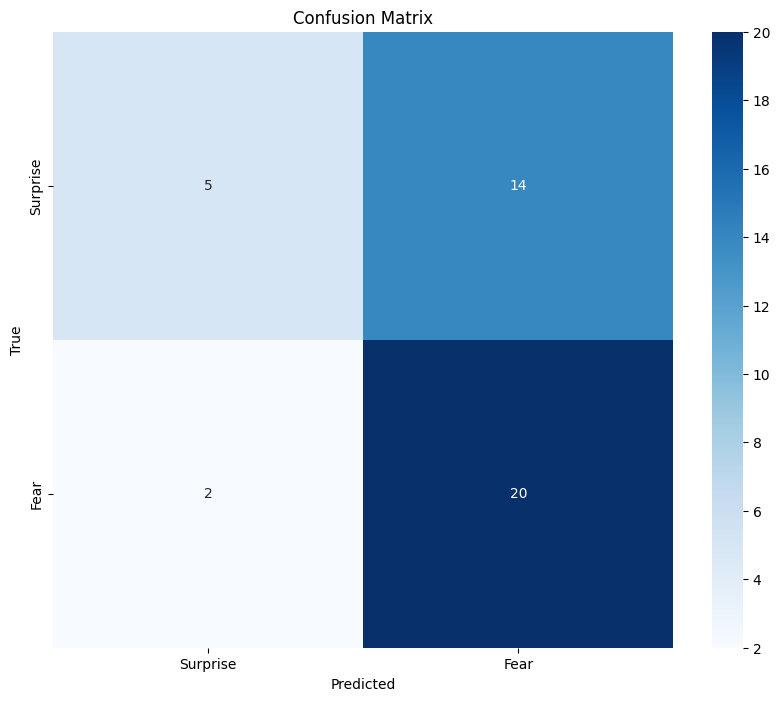

In [36]:
# ref: https://www.w3schools.com/python/python_ml_confusion_matrix.asp

cm = confusion_matrix(val_labels, val_predictions)

print(cm)

ticks = ["Surprise", "Fear"]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ticks, yticklabels=ticks)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Evaluation

___

#### Training

#### Validation